![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2F03+-+BigQuery+ML+%28BQML%29&file=03g+-+BQML+-+PCA+with+Anomaly+Detection.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/03%20-%20BigQuery%20ML%20%28BQML%29/03g%20-%20BQML%20-%20PCA%20with%20Anomaly%20Detection.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2F03%2520-%2520BigQuery%2520ML%2520%2528BQML%2529%2F03g%2520-%2520BQML%2520-%2520PCA%2520with%2520Anomaly%2520Detection.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/03%20-%20BigQuery%20ML%20%28BQML%29/03g%20-%20BQML%20-%20PCA%20with%20Anomaly%20Detection.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/03%20-%20BigQuery%20ML%20%28BQML%29/03g%20-%20BQML%20-%20PCA%20with%20Anomaly%20Detection.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# 03g - BigQuery ML (BQML) - PCA with Anomaly Detection

In this notebook, BigQuery ML (BQML) is used to do a principal Component analysis (PCA).

**Principal component analysis, PCA**

Principal component analysis, or PCA, is a statistical technique for linearly transforming a set of features into a new coordinate system with fewer features all while preserving as much of the information (variation) as possible.  This is an unsupervised learning approach requiring no labels that results in a smaller feature set where the derived features/components are orthoganal to each other.  The number of components can be specified directly or set by the desired variance to be explained.  One way to think of this method is fitting an elipse with a number of dimensions, `p`, where the axes are orthogonal and their relative size represents amount of variance explained by the component (dimension).

Reference:
- [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)
- [Unsupervised Learning](https://en.wikipedia.org/wiki/Unsupervised_learning)

**BigQuery ML (BQML)**

BigQuery has a number of machine learning algorithms callable directly from SQL.  This gives the convenience of using the common language of `SQL` with statments like `CREATE MODEL …`.  The library of available models is constantly growing and covers supervised, unsupervised, and time series methods as well as functions for evaluation - even anomaly detection from results, explainability and hyperparameter tuning.  A great starting point for seeing the scope of available methods is the [user journey for models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).

**Prerequisites:**
- [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb)

**Resources:**
-  [BigQuery ML (BQML) Overview](https://cloud.google.com/bigquery-ml/docs/introduction)
-  [Overview of BQML methods and workflows](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)
- [BigQuery](https://cloud.google.com/bigquery)
    - [Documentation:](https://cloud.google.com/bigquery/docs/query-overview)
    - [API:](https://cloud.google.com/bigquery/docs/reference/libraries-overview)
        - [Clients](https://cloud.google.com/bigquery/docs/reference/libraries)
            - [Python SDK:](https://github.com/googleapis/python-bigquery)
            - [Python Library Reference:](https://cloud.google.com/python/docs/reference/bigquery/latest)
- [Vertex AI](https://cloud.google.com/vertex-ai)
    - [Documentation:](https://cloud.google.com/vertex-ai/docs/start/introduction-unified-platform)
    - [API:](https://cloud.google.com/vertex-ai/docs/reference)
        - [Clients:](https://cloud.google.com/vertex-ai/docs/start/client-libraries)
            - [Python SDK:](https://github.com/googleapis/python-aiplatform)
            - [Python Library Reference:](https://cloud.google.com/python/docs/reference/aiplatform/latest)

**Conceptual Flow & Workflow**


---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/03%20-%20BigQuery%20ML%20(BQML)/03g%20-%20BQML%20-%20PCA%20with%20Anomaly%20Detection.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    
    #installs
    # Vertex AI GenAI Studio SDK - Update the aiplatform SDK
    !pip install google.cloud.aiplatform -U -q --user
    !pip install --upgrade gcsfs -U -q --user
    !pip install --upgrade google-cloud-bigquery -U -q --user
    !pip install --upgrade google-cloud-bigquery-storage -U -q --user
    
    # Enable Vertex AI For This Project
    !gcloud services enable aiplatform.googleapis.com

    # restart runtime
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)    
except Exception:
    pass

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = 'pca'
SERIES = 'bqml'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources for serving BigQuery Model Exports
TF_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'
XGB_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.0-82:latest'

# Resources for serving BigQuery Model Exports
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

from google.api import httpbody_pb2
import json

clients:

In [4]:
bq = bigquery.Client(project = PROJECT_ID)
aiplatform.init(project = PROJECT_ID, location = REGION)

parameters:

In [5]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"
RUN_NAME = f'run-{TIMESTAMP}'

BQ_MODEL = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}'

environment:

In [6]:
DIR = f"temp/{EXPERIMENT}"

!rm -rf {DIR}
!mkdir -p {DIR}

---
## Review Data

The data source here was prepared in [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb).  In this notebook we will use prepared BigQuery table to build a model with BigQuery ML (BQML).

This is a table of 284,807 credit card transactions classified as fradulant or normal in the column `Class`.  In order protect confidentiality, the original features have been transformed using [principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) into 28 features named `V1, V2, ... V28` (float).  Two descriptive features are provided without transformation by PCA:
- `Time` (integer) is the seconds elapsed between the transaction and the earliest transaction in the table
- `Amount` (float) is the value of the transaction

The data preparation included added splits for machine learning with a column named `splits` with 80% for training (`TRAIN`), 10% for validation (`VALIDATE`) and 10% for testing (`TEST`).  Additionally, a unique identifier was added to each transaction, `transaction_id`.  

Review the number of records for each level of Class (VAR_TARGET) for each of the data splits:

In [7]:
query = f"""
SELECT splits, {VAR_TARGET}, count(*) as n
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
GROUP BY splits, {VAR_TARGET}
"""
bq.query(query = query).to_dataframe()

,splits,Class,n
0,TEST,0,28455
1,TEST,1,47
2,TRAIN,0,227664
3,TRAIN,1,397
4,VALIDATE,0,28196
5,VALIDATE,1,48


Further review the balance of the target variable (VAR_TARGET) for each split as a percentage of the split:

In [8]:
query = f"""
WITH
    COUNTS as (SELECT splits, {VAR_TARGET}, count(*) as n FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` GROUP BY splits, {VAR_TARGET})
    
SELECT *,
    SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY {VAR_TARGET})) as n_pct_class,
    SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY splits)) as n_pct_split,
    SAFE_DIVIDE(SUM(n) OVER(PARTITION BY {VAR_TARGET}), SUM(n) OVER()) as class_pct_total
FROM COUNTS
"""
review = bq.query(query = query).to_dataframe()
review

,splits,Class,n,n_pct_class,n_pct_split,class_pct_total
0,TRAIN,1,397,0.806911,0.001741,0.001727
1,TEST,1,47,0.095528,0.001649,0.001727
2,TEST,0,28455,0.100083,0.998351,0.998273
3,VALIDATE,0,28196,0.099172,0.998301,0.998273
4,TRAIN,0,227664,0.800746,0.998259,0.998273
5,VALIDATE,1,48,0.097561,0.001699,0.001727


Retrive the rate of fraud, `Class = 1`, for the training data split.  This will be used later as the expected contamination rate for the records in the test split when doing anomaly detection.

In [9]:
TRAIN_FRAUD_PCT = review.loc[(review[f'{VAR_TARGET}'] == 1) & (review['splits'] == 'TRAIN'), 'n_pct_split'].values[0]
TRAIN_FRAUD_PCT

0.0017407623399002899

---
## This Run

In [10]:
print(f'This run will create BQML model: {BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
print(f'This run will create Vertex AI model: {BQ_PROJECT}.{BQ_DATASET}.bqml_{SERIES}_{EXPERIMENT}')
print(f'The runs timestamp Is: {TIMESTAMP}')

This run will create BQML model: statmike-mlops-349915.fraud.bqml_pca_20230627152542
This run will create Vertex AI model: statmike-mlops-349915.fraud.bqml_bqml_pca
The runs timestamp Is: 20230627152542


---
## Train Model

Use BigQuery ML to train unsupervised PCA model:
- [PCA](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-pca) with BigQuery ML (BQML)
- This uses the `splits` column that notebook `01` created to subset to the training data
    - not directly used by the `PCA` training but used to subset to the `splits = 'TRAIN'` data for training
    
This example includes the [training options](https://cloud.google.com/bigquery-ml/docs/create_vertex) to register the resulting model in the [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).

In [11]:
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
OPTIONS (
        model_type = 'PCA',
        pca_explained_variance_ratio = 0.90,
        scale_features = TRUE,
        pca_solver = 'AUTO',
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_{SERIES}_{EXPERIMENT}',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['{RUN_NAME}']
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT.split())}, splits, {VAR_TARGET})
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
WHERE splits = 'TRAIN'
"""
print(query)


CREATE OR REPLACE MODEL `statmike-mlops-349915.fraud.bqml_pca_20230627152542`
OPTIONS (
        model_type = 'PCA',
        pca_explained_variance_ratio = 0.90,
        scale_features = TRUE,
        pca_solver = 'AUTO',
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_bqml_pca',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['run-20230627152542']
    ) AS
SELECT * EXCEPT(transaction_id, splits, Class)
FROM `statmike-mlops-349915.fraud.fraud_prepped`
WHERE splits = 'TRAIN'



In [12]:
job = bq.query(query = query)
job.result()

In [13]:
(job.ended-job.started).total_seconds()

39.307

In [14]:
job.total_bytes_processed

70403559

Add labels to the model in BigQuery:

In [15]:
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
model.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
model = bq.update_model(model, ['labels'])

### Check out this model in BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [16]:
print(f'BigQuery Console for Project:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}')

BigQuery Console for Project:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915


In [17]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sfraud!3sbqml_pca_20230627152542


### Check out this model in the Vertex AI Model Registry

In [19]:
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/bqml_{BQ_MODEL}?project={PROJECT_ID}')

Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/bqml_bqml_pca_20230627152542?project=statmike-mlops-349915


### Feature and Training Review

Review the Model Inputs, the feature information, with [ML.FEATURE_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature):

In [20]:
feature_info = bq.query(
    query = f"""
        SELECT *
        FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
feature_info

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,Time,0.000000,172792.000000,94811.116749,85780.000000,47493.531641,<NA>,0,<NA>
1,V1,-56.407510,2.454930,-0.000215,0.036678,1.958173,<NA>,0,<NA>
2,V2,-72.715728,22.057729,0.000316,0.062688,1.649662,<NA>,0,<NA>
3,V3,-48.325589,9.382558,-0.000525,0.184898,1.520173,<NA>,0,<NA>
4,V4,-5.600607,16.875344,0.000695,-0.040169,1.415309,<NA>,0,<NA>
5,V5,-113.743307,34.801666,-0.001264,-0.060604,1.381807,<NA>,0,<NA>
6,V6,-26.160506,73.301626,0.002089,-0.265520,1.334135,<NA>,0,<NA>
7,V7,-43.557242,120.589494,-0.000721,0.035703,1.245465,<NA>,0,<NA>
8,V8,-73.216718,19.168327,-0.001064,0.025569,1.205023,<NA>,0,<NA>
9,V9,-13.434066,15.594995,0.001406,-0.049285,1.100121,<NA>,0,<NA>


Review the iterations from training with [ML.TRAINING_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train):

In [21]:
history = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        ORDER BY iteration"""
).to_dataframe()
history

,training_run,iteration,duration_ms
0,0,0,5925


---
## Evaluate Model

Review the evaluation statistics on the trials with [ML.EVALUATE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [22]:
eval = bq.query(
    query = f"""
        SELECT *
        FROM ML.EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
eval

,total_explained_variance_ratio
0,0.923359


Review the principal components with [ML.PRINCIPAL_COMPONENT_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-principal-component-info):

In [23]:
pc_info = bq.query(
    query = f"""
        SELECT *
        FROM ML.PRINCIPAL_COMPONENT_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
pc_info

,principal_component_id,eigenvalue,explained_variance_ratio,cumulative_explained_variance_ratio
0,0,1.965330,0.065511,0.065511
1,1,1.681695,0.056056,0.121567
2,2,1.045826,0.034861,0.156428
3,3,1.027172,0.034239,0.190667
4,4,1.018633,0.033954,0.224622
5,5,1.013150,0.033772,0.258394
6,6,1.008045,0.033602,0.291995
7,7,1.006076,0.033536,0.325531
8,8,1.004075,0.033469,0.359000
9,9,1.003322,0.033444,0.392444


Review the principal components with [ML.PRINCIPAL_COMPONENTS](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-principal-components):

In [24]:
pc = bq.query(
    query = f"""
        SELECT *
        FROM ML.PRINCIPAL_COMPONENTS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
pc

,principal_component_id,feature,numerical_value,categorical_value
0,0,Time,0.031008,[]
1,0,V1,0.174601,[]
2,0,V2,0.395097,[]
3,0,V3,0.143194,[]
4,0,V4,-0.079480,[]
...,...,...,...,...
775,25,V25,0.131626,[]
776,25,V26,-0.010290,[]
777,25,V27,0.068330,[]
778,25,V28,-0.078994,[]


---
## Predictions With BigQuery ML (BQML)

Create a pandas dataframe with retrieved predictions for the test data in the table using [ML.PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict):

In [25]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
pred = bq.query(query = query).to_dataframe()

Review the columns from the predictions.  Note that the query added columns for each principal component for each example in the test data.

In [26]:
pred.head()

,principal_component_1,principal_component_2,principal_component_3,principal_component_4,principal_component_5,principal_component_6,principal_component_7,principal_component_8,principal_component_9,principal_component_10,...,principal_component_20,principal_component_21,principal_component_22,principal_component_23,principal_component_24,principal_component_25,principal_component_26,Class,transaction_id,splits
0,0.703924,-0.540772,-5.491594,0.186916,-1.930816,0.353415,0.435779,2.508127,0.633616,0.148357,...,1.297797,0.427773,1.208755,-1.562841,-0.555793,1.286651,3.101754,0,d3190904-6b83-43ff-9ce4-f264a870d6b5,TEST
1,0.566274,2.031380,-0.067111,-0.919701,0.829399,-0.055052,0.736723,0.983814,1.226231,0.991344,...,-0.463842,-0.545200,1.674171,-0.337617,0.514809,0.156895,-0.139028,0,d6c16eba-2b09-4230-9e4d-7e7182727bac,TEST
2,0.504729,-1.143541,0.036500,-0.042869,0.177656,-0.383138,0.794985,1.026783,0.069820,-0.004590,...,0.400295,-1.349959,-1.679026,-1.368204,-0.341461,0.954940,0.281566,0,2847f443-173c-45ab-9164-a9a34a760eac,TEST
3,0.432782,0.850862,0.181634,0.161824,-0.318361,-0.672686,0.242004,0.769778,0.603034,-0.289569,...,1.308512,-1.256250,-0.427850,-0.759690,-1.064782,0.223467,0.089624,0,2f832a90-694a-47d1-8e5d-5af3811d6d3d,TEST
4,0.518711,-0.971422,-0.174134,0.359595,0.002356,-0.519046,-0.084404,3.531022,1.551561,-1.573056,...,0.944023,-0.973354,-0.780529,-1.404871,-0.747476,1.064180,0.378965,0,39973f10-f357-4678-8728-b7bace167800,TEST


---
## Anomalies
Use the [ML.DETECT_ANOMALIES](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-detect-anomalies) function to retrieve rows that appear as anomalies with the input [contamination](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-detect-anomalies#contamination) value set to the rate of fraud in the training data (calculated above).

In [27]:
query = f"""
WITH ANOMALIES AS (
        SELECT *
        FROM ML.DETECT_ANOMALIES (
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
            STRUCT ({TRAIN_FRAUD_PCT} AS contamination),
            (SELECT *
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE splits = 'TEST')
          )
)
SELECT *
FROM ANOMALIES
WHERE is_anomaly = TRUE
"""
anomalies = bq.query(query = query).to_dataframe()

In [28]:
anomalies

,is_anomaly,mean_squared_error,Time,V1,V2,V3,V4,V5,V6,V7,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,True,7.258645,127486,-11.845764,-19.653340,-0.022641,4.983757,17.176972,-11.561096,-12.457395,...,3.887353,0.161235,-0.444238,0.995712,-0.739107,0.218287,107.85,0,fb32b62f-9c62-4031-a7dc-71c1600c9c54,TEST
1,True,11.029368,74657,-16.743851,-19.511968,-7.214609,8.345571,-11.322894,8.606982,14.113144,...,9.016942,-0.859535,1.048808,0.438797,4.250372,-5.954281,3759.39,0,03324231-8b4c-4a98-a521-ab626f5d232d,TEST
2,True,87.240561,126271,-19.618019,-18.539382,-4.310085,6.787660,3.201194,-0.760207,2.172656,...,-6.637055,0.754359,0.335719,-0.501723,-8.703068,16.129609,175.00,0,efd74f88-9ba0-4ffb-8966-9aaa8a9c0be1,TEST
3,True,15.790477,137934,-15.168474,-19.190285,-1.749319,2.999120,8.141815,-4.746811,-5.319852,...,-5.041949,-0.983799,-1.076277,-0.460614,2.756117,-4.639338,814.25,0,53b1be4c-01ae-48d3-a066-7a35bd800079,TEST
4,True,8.579512,133013,-8.250844,-4.848971,-1.815623,0.332288,0.038812,0.103141,1.088345,...,-2.497822,0.518712,-0.017827,-0.542502,-2.950622,4.484648,319.60,0,acf9ab00-28ad-4500-9645-6ad0b240a492,TEST
5,True,8.091865,28197,-6.243976,-3.778666,2.100628,-0.735784,1.538913,0.042233,2.884848,...,-1.302455,0.235380,0.216960,-1.013667,-6.250280,1.609820,106.02,0,dbd72c31-068e-48ea-ac13-79e96b6f1563,TEST
6,True,7.631460,126880,-11.147600,-2.729791,-2.453181,-0.090319,4.735873,4.266768,-6.935396,...,-4.444377,1.072178,-0.699370,-0.413413,1.938789,-3.112369,73.39,0,889c552e-f6c7-4251-93a4-3ba81bcce7fb,TEST
7,True,5.451931,106718,-6.917175,-6.307233,0.864905,4.964396,9.531662,-4.963994,-4.846095,...,-3.403068,1.007968,-0.834347,0.072207,1.619355,-0.521913,1.09,0,69ddf7da-ca77-4a6a-ae8f-26efd32bef5e,TEST
8,True,5.083153,160076,-9.140426,-10.141234,-1.447399,5.813844,2.602126,-2.505608,-2.293672,...,-2.532990,0.387053,-3.028482,-0.523624,2.244502,-2.721089,810.29,0,6e752268-13fc-4249-955c-2475d011d3d7,TEST
9,True,54.983927,128683,-26.615445,-24.726002,-7.846517,5.647523,4.561666,-2.520332,-4.892119,...,-18.227295,0.400321,-2.930137,-0.334146,5.002832,-0.747816,1042.80,0,fbdf95c2-779e-4e8c-9241-18e6e7bf8097,TEST


Use anomaly detection information to create confusion matrix with know classification:

In [29]:
query = f"""
WITH ANOMALIES AS (
        SELECT {VAR_TARGET},
            CASE
                WHEN is_anomaly = TRUE THEN 1
                WHEN is_anomaly = FALSE THEN 0
            END as predicted_{VAR_TARGET}
        FROM ML.DETECT_ANOMALIES (
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
            STRUCT ({TRAIN_FRAUD_PCT} AS contamination),
            (SELECT *
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE splits = 'TEST')
          )
      )
SELECT predicted_{VAR_TARGET}, {VAR_TARGET}, count(*) as count
FROM ANOMALIES
GROUP BY predicted_{VAR_TARGET}, {VAR_TARGET}
"""
bq.query(query = query).to_dataframe()

,predicted_Class,Class,count
0,0,0,28398
1,1,0,57
2,0,1,47


---
## Custom Eval Metrics
Retrieve the predictions to a local dataframe and use [scikit-learn](https://scikit-learn.org/stable/index.html) metrics [fuctions](https://scikit-learn.org/stable/modules/model_evaluation.html) to do model evaluation.

In [30]:
query = f"""
SELECT {VAR_TARGET},
    CASE
        WHEN is_anomaly = TRUE THEN 1
        WHEN is_anomaly = FALSE THEN 0
    END as predicted_{VAR_TARGET}
FROM ML.DETECT_ANOMALIES (
    MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    STRUCT ({TRAIN_FRAUD_PCT} AS contamination),
    (SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
results = bq.query(query = query).to_dataframe()
results

,Class,predicted_Class
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
28497,0,0
28498,0,0
28499,0,0
28500,0,0


In [31]:
metrics.confusion_matrix(list(results[f'{VAR_TARGET}']), list(results[f'predicted_{VAR_TARGET}']))

array([[28398,    57],
       [   47,     0]])

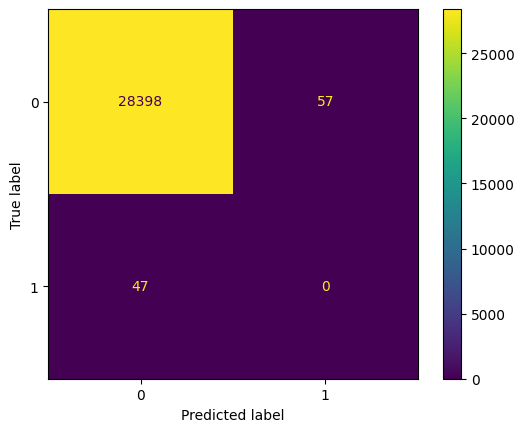

In [32]:
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(list(results[f'{VAR_TARGET}']), list(results[f'predicted_{VAR_TARGET}']))
)
disp.plot()

In [33]:
metrics.accuracy_score(list(results[f'{VAR_TARGET}']), list(results[f'predicted_{VAR_TARGET}']))

0.9963511332538068

In [34]:
print(metrics.classification_report(list(results[f'{VAR_TARGET}']), list(results[f'predicted_{VAR_TARGET}'])))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28455
           1       0.00      0.00      0.00        47

    accuracy                           1.00     28502
   macro avg       0.50      0.50      0.50     28502
weighted avg       1.00      1.00      1.00     28502



---
## Serving With Vertex AI

The training options for creating the model include registering the model the Vertex AI Automatically.  This makes deploying the model to a [Vertex AI Endpoint for online serving](https://cloud.google.com/vertex-ai/docs/general/deployment) very easy.

### Vertex AI Model Registry - Get Model

When these modes were trained in BigQuery ML they included options for registration in Vertex AI Model Registry.  This section shows how to retrieve the information from the model using the [Vertex AI Python Client](../Tips/aiplatform_notes.md).

References:
- [aiplatform.Model()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [35]:
vertex_model = aiplatform.Model(model_name = f'bqml_{SERIES}_{EXPERIMENT}')
vertex_model.resource_name

'projects/1026793852137/locations/us-central1/models/bqml_bqml_pca'

In [37]:
# note: this is blank since the model is managed by BQML and container is pre-specified
vertex_model.uri 

### Vertex AI Endpoint - Create or Retrieve

References:
- [aiplatform.Endpoint()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint)

In [38]:
if not aiplatform.Endpoint.list(filter = f"display_name={SERIES}"):
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}",
        labels = {'series' : f"{SERIES}"}
    )
    print(f"Endpoint Created: {endpoint.display_name}")
else:
    endpoint = aiplatform.Endpoint.list(filter = f"display_name={SERIES}")[0]
    print(f"Endpoint Found: {endpoint.display_name}")

Endpoint Found: bqml


In [39]:
endpoint.display_name

'bqml'

In [40]:
endpoint.traffic_split

{'331245470053564416': 100}

In [41]:
deployed_models = endpoint.list_models()
deployed_models

[id: "331245470053564416"
 model: "projects/1026793852137/locations/us-central1/models/bqml_bqml_wide-and-deep-nn"
 display_name: "bqml_bqml_wide-and-deep-nn"
 create_time {
   seconds: 1687887708
   nanos: 179433000
 }
 dedicated_resources {
   machine_spec {
     machine_type: "n1-standard-2"
   }
   min_replica_count: 1
   max_replica_count: 1
 }
 explanation_spec {
   parameters {
     integrated_gradients_attribution {
       step_count: 10
     }
   }
   metadata {
     inputs {
       key: "Amount"
       value {
         input_tensor_name: "dnn/input_from_feature_columns/input_layer/Amount/Cast:0"
         encoding: IDENTITY
         modality: "numeric"
       }
     }
     inputs {
       key: "Time"
       value {
         input_tensor_name: "dnn/input_from_feature_columns/input_layer/Time/Cast:0"
         encoding: IDENTITY
         modality: "numeric"
       }
     }
     inputs {
       key: "V1"
       value {
         input_tensor_name: "dnn/input_from_feature_columns/in

### Deploy Model To Vertex AI Endpoint

**NOTE: This can take 15+ minutes to complete.**

Reference:
- [aiplatform.Endpoint.deploy()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint#google_cloud_aiplatform_Endpoint_deploy)

In [42]:
endpoint.deploy(
    model = vertex_model,
    deployed_model_display_name = vertex_model.display_name,
    traffic_percentage = 100,
    machine_type = 'n1-standard-2',
    min_replica_count = 1,
    max_replica_count = 1
)

Deploying Model projects/1026793852137/locations/us-central1/models/bqml_bqml_pca to Endpoint : projects/1026793852137/locations/us-central1/endpoints/5386265571916513280
Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/5386265571916513280/operations/8395542241879261184
Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/5386265571916513280


In [43]:
endpoint.list_models()

[id: "331245470053564416"
 model: "projects/1026793852137/locations/us-central1/models/bqml_bqml_wide-and-deep-nn"
 display_name: "bqml_bqml_wide-and-deep-nn"
 create_time {
   seconds: 1687887708
   nanos: 179433000
 }
 dedicated_resources {
   machine_spec {
     machine_type: "n1-standard-2"
   }
   min_replica_count: 1
   max_replica_count: 1
 }
 explanation_spec {
   parameters {
     integrated_gradients_attribution {
       step_count: 10
     }
   }
   metadata {
     inputs {
       key: "Amount"
       value {
         input_tensor_name: "dnn/input_from_feature_columns/input_layer/Amount/Cast:0"
         encoding: IDENTITY
         modality: "numeric"
       }
     }
     inputs {
       key: "Time"
       value {
         input_tensor_name: "dnn/input_from_feature_columns/input_layer/Time/Cast:0"
         encoding: IDENTITY
         modality: "numeric"
       }
     }
     inputs {
       key: "V1"
       value {
         input_tensor_name: "dnn/input_from_feature_columns/in

### Remove Deployed Models without Traffic

In [44]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

Undeploying Endpoint model: projects/1026793852137/locations/us-central1/endpoints/5386265571916513280
Undeploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/5386265571916513280/operations/120740876539396096
Endpoint model undeployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/5386265571916513280
Undeploying bqml_bqml_wide-and-deep-nn with version 1 because it has no traffic.
Model bqml_bqml_pca with version 1 has traffic = 100


In [45]:
endpoint.traffic_split

{'5519392240784375808': 100}

In [46]:
#endpoint.list_models()

---
## Predictions With Vertex AI Endpoint

### Retrieve Records For Prediction

In [47]:
n = 10
pred = bq.query(
    query = f"""
        SELECT * EXCEPT({VAR_TARGET}, {VAR_OMIT}, splits)
        FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}
        WHERE splits='TEST'
        LIMIT {n}
        """
).to_dataframe()

Shape as instances: dictionaries of key:value pairs for only features used in model

In [48]:
newobs = pred.to_dict(orient = 'records')

In [49]:
newobs[0]

{'Time': 35337,
 'V1': 1.0928441854981998,
 'V2': -0.0132303486713432,
 'V3': 1.35982868199426,
 'V4': 2.7315370965921004,
 'V5': -0.707357349219652,
 'V6': 0.8738370029866129,
 'V7': -0.7961301510622031,
 'V8': 0.437706509544851,
 'V9': 0.39676985012996396,
 'V10': 0.587438102569443,
 'V11': -0.14979756231827498,
 'V12': 0.29514781622888103,
 'V13': -1.30382621882143,
 'V14': -0.31782283120234495,
 'V15': -2.03673231037199,
 'V16': 0.376090905274179,
 'V17': -0.30040350116459497,
 'V18': 0.433799615590844,
 'V19': -0.145082264348681,
 'V20': -0.240427548108996,
 'V21': 0.0376030733329398,
 'V22': 0.38002620963091405,
 'V23': -0.16764742731151097,
 'V24': 0.0275573495476881,
 'V25': 0.59211469704354,
 'V26': 0.219695164116351,
 'V27': 0.0369695108704894,
 'V28': 0.010984441006191,
 'Amount': 0.0}

### Get Predictions: Python Client

In [50]:
prediction = endpoint.predict(instances = newobs[0:1])
prediction

Prediction(predictions=[{'principal_component_projections': [0.4061861467049647, 1.142429036767022, 0.1797601735725115, -0.02712136401087156, 0.2419318102449056, -0.1717972859760072, 1.963969925923904, 0.3381761316515224, 0.2413168475089292, 0.8576724721238839, -1.000130223422447, 1.004431960543296, -1.612831599123362, -0.314707972362103, 1.013403118677192, 0.7075492028374176, -1.584721170444826, -0.1587943390694643, -0.08639166102246394, 0.5986228270738121, -0.8235495575977535, -0.6350921716448534, -0.6830334984171708, 0.2011286672084854, -0.2954770089315091, 0.08770761978421224], 'principal_component_ids': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0]}], deployed_model_id='5519392240784375808', model_version_id='1', model_resource_name='projects/1026793852137/locations/us-central1/models/bqml_bqml_pca', explanations=None)

In [51]:
prediction.predictions[0]

{'principal_component_projections': [0.4061861467049647,
  1.142429036767022,
  0.1797601735725115,
  -0.02712136401087156,
  0.2419318102449056,
  -0.1717972859760072,
  1.963969925923904,
  0.3381761316515224,
  0.2413168475089292,
  0.8576724721238839,
  -1.000130223422447,
  1.004431960543296,
  -1.612831599123362,
  -0.314707972362103,
  1.013403118677192,
  0.7075492028374176,
  -1.584721170444826,
  -0.1587943390694643,
  -0.08639166102246394,
  0.5986228270738121,
  -0.8235495575977535,
  -0.6350921716448534,
  -0.6830334984171708,
  0.2011286672084854,
  -0.2954770089315091,
  0.08770761978421224],
 'principal_component_ids': [0.0,
  1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  6.0,
  7.0,
  8.0,
  9.0,
  10.0,
  11.0,
  12.0,
  13.0,
  14.0,
  15.0,
  16.0,
  17.0,
  18.0,
  19.0,
  20.0,
  21.0,
  22.0,
  23.0,
  24.0,
  25.0]}

In [52]:
np.argmax(prediction.predictions[0])

0

### Get Predictions: REST
Reference:
- [POST https://{REGION}-aiplatform.googleapis.com/v1/{endpoint}:predict](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.prediction_service.PredictionServiceClient#google_cloud_aiplatform_v1_services_prediction_service_PredictionServiceClient_predict)

Prepare request:

In [53]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": newobs[0:1]}))

Prediction:

In [54]:
prediction = !curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

prediction

['  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current',
 '                                 Dload  Upload   Total   Spent    Left  Speed',
 '',
 '  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0',
 '100  2173    0  1378  100   795  19138  11041 --:--:-- --:--:-- --:--:-- 30180',
 '{',
 '  "predictions": [',
 '    {',
 '      "principal_component_ids": [',
 '        0,',
 '        1,',
 '        2,',
 '        3,',
 '        4,',
 '        5,',
 '        6,',
 '        7,',
 '        8,',
 '        9,',
 '        10,',
 '        11,',
 '        12,',
 '        13,',
 '        14,',
 '        15,',
 '        16,',
 '        17,',
 '        18,',
 '        19,',
 '        20,',
 '        21,',
 '        22,',
 '        23,',
 '        24,',
 '        25',
 '      ],',
 '      "principal_component_projections": [',
 '        0.40618614670496472,',
 '        1.142429036767022,',
 '        0.17976017357251151,',
 '        -0.0271213640

Format raw prediction response using JSON:

### Get Predictions: gcloud (CLI)
Reference:
- [gcloud ai endpoints predict](https://cloud.google.com/sdk/gcloud/reference/ai/endpoints/predict)

Prepare request:

In [55]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": newobs[0:1]}))

Prediction:

In [56]:
prediction = !gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json
prediction

['Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]',
 "[{'principal_component_ids': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 'principal_component_projections': [0.4061861467049647, 1.142429036767022, 0.1797601735725115, -0.02712136401087156, 0.2419318102449056, -0.1717972859760072, 1.963969925923904, 0.3381761316515224, 0.2413168475089292, 0.8576724721238839, -1.000130223422447, 1.004431960543296, -1.612831599123362, -0.314707972362103, 1.013403118677192, 0.7075492028374176, -1.584721170444826, -0.1587943390694643, -0.08639166102246394, 0.5986228270738121, -0.8235495575977535, -0.6350921716448534, -0.6830334984171708, 0.2011286672084854, -0.2954770089315091, 0.08770761978421224]}]"]

---
## Export Model

The model created in BigQuery ML can be exported to their native model types save files.  This process saves the model artifacts in GCS where they can be use anywhere they are needed.  For instance, they could be imported into the Vertex AI Model Registry for use in online and batch serving - however, this process is automated with the training options use above.

### Export the BigQuery Model


The models trained in BQML can be exported from BigQuery to GCS:

Reference:
- [Exporting Models](https://cloud.google.com/bigquery-ml/docs/exporting-models)

In [57]:
query = f"""
EXPORT MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (URI = 'gs://{BUCKET}/{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model')
"""
export = bq.query(query = query)
export.result()

In [58]:
(export.ended - export.started).total_seconds()

30.897

In [59]:
listing = !gsutil ls gs://{BUCKET}/{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model
listing

['gs://statmike-mlops-349915/bqml/pca/models/20230627152542/model/',
 'gs://statmike-mlops-349915/bqml/pca/models/20230627152542/model/fingerprint.pb',
 'gs://statmike-mlops-349915/bqml/pca/models/20230627152542/model/saved_model.pb',
 'gs://statmike-mlops-349915/bqml/pca/models/20230627152542/model/variables/']

In [60]:
print(f"View the export in the console:\nhttps://console.cloud.google.com/storage/browser/{BUCKET}/{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model?project={PROJECT_ID}")

View the export in the console:
https://console.cloud.google.com/storage/browser/statmike-mlops-349915/bqml/pca/models/20230627152542/model?project=statmike-mlops-349915


### Detect The Model Types Framework

In [61]:
filetype = {'pb': 'TensorFlow', 'bst': 'XGBoost'}

filetypes = [filetype[f.split('.')[-1]] for f in listing if f.split('.')[-1] in ['pb','bst']]
if len(list(set(filetypes))) == 1:
    framework = filetypes[0]
    print(f'framework = {framework}')
else:
    raise TypeError(f"Model Type Undeteremined!! Review the contents of of 'listing = {listing}'.")

framework = TensorFlow


In [62]:
list(set(filetypes))

['TensorFlow']

---
## Remove Resources

The following cells have commented out statements that can be used to remove resources created by this notebook.  Other notebooks in the repository will reusue the same endpoint so it may be desired to not remove the endpoint if you plan to run additional notebooks.  Otherwise, please removed the endpoint to prevent ongoing cost from hosting the models on Vertex AI Endpoints.

Similarly, if you want to remove the model from BQML to prevent the minimal storage cost it will automatically be removed from Vertex AI Model Registry as well.

In [100]:
# delete endpoint, use `force` incase models are deployed or undeploy them first
#endpoint.delete(force = True)

In [99]:
# delete models created in BQ with BQML - this also removes them from Vertex AI Model Registry
#bq.delete_model(model)